# Home Credit Default Risk -This notebook demonstrates the complete model training workflow, including:

Data preparation and preprocessing

Training and comparison of multiple algorithms

Model evaluation and validation

Feature importance analysis

Model interpretation and business insights

In [ ]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# custom modules
import sys
sys.path.append('../')

from src.models.model_trainer import ModelTrainer
from src.utils.visualization import DataVisualizer

## 1. 数据加载和准备

In [2]:
# 加载特征工程后的数据
print("加载特征数据...")
train_features = pd.read_csv('../data/processed/train_features.csv')
test_features = pd.read_csv('../data/processed/test_features.csv')

print(f"训练集形状: {train_features.shape}")
print(f"测试集形状: {test_features.shape}")
print(f"目标变量分布: {train_features['TARGET'].value_counts()}")
print(f"违约率: {train_features['TARGET'].mean():.4f}")

加载特征数据...
训练集形状: (307511, 326)
测试集形状: (48744, 325)
目标变量分布: TARGET
0    282686
1     24825
Name: count, dtype: int64
违约率: 0.0807


## 2. 数据预处理

In [3]:
# 初始化模型训练器
trainer = ModelTrainer(n_folds=5, random_state=42)

# 准备训练数据
print("准备训练数据...")
X_train, y_train, X_test = trainer.prepare_data(train_features, test_features, 'TARGET')

print(f"\n预处理完成!")
print(f"X_train形状: {X_train.shape}")
print(f"X_test形状: {X_test.shape}")
print(f"y_train形状: {y_train.shape}")

准备训练数据...
训练集形状: (307511, 324)
测试集形状: (48744, 324)
数值特征: 324
分类特征: 0
正样本比例: 0.0807

预处理完成!
X_train形状: (307511, 324)
X_test形状: (48744, 324)
y_train形状: (307511,)


## 3. LightGBM模型训练

In [5]:
# 训练LightGBM模型
print("训练LightGBM模型...")
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

lgb_result = trainer.train_lightgbm(X_train, y_train, X_test, lgb_params)
print(f"\nLightGBM训练完成!")
print(f"OOF AUC: {lgb_result['oof_auc']:.6f}")
print(f"CV AUC: {np.mean(lgb_result['cv_scores']):.6f} ± {np.std(lgb_result['cv_scores']):.6f}")

训练LightGBM模型...
开始训练LightGBM模型...
训练第 1 折...
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[537]	training's auc: 0.894976	valid_1's auc: 0.782662
第 1 折 AUC: 0.782662
训练第 2 折...
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[465]	training's auc: 0.884419	valid_1's auc: 0.791681
第 2 折 AUC: 0.791681
训练第 3 折...
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[573]	training's auc: 0.899346	valid_1's auc: 0.781925
第 3 折 AUC: 0.781925
训练第 4 折...
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[697]	training's auc: 0.914486	valid_1's auc: 0.788609
第 4 折 AUC: 0.788609
训练第 5 折...
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[897]	training's auc: 0.932633	valid_1's auc: 0.782139
第 5 折 AUC: 0.782139
OOF AUC: 0.785266
CV AUC: 0.785403 +/- 0.003999

Li

## 4. XGBoost模型训练

In [4]:
# 训练XGBoost模型
print("训练XGBoost模型...")
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'verbosity': 0
}

xgb_result = trainer.train_xgboost(X_train, y_train, X_test, xgb_params)
print(f"\nXGBoost训练完成!")
print(f"OOF AUC: {xgb_result['oof_auc']:.6f}")
print(f"CV AUC: {np.mean(xgb_result['cv_scores']):.6f} ± {np.std(xgb_result['cv_scores']):.6f}")

训练XGBoost模型...
开始训练XGBoost模型...
训练第 1 折...
第 1 折 AUC: 0.784737
训练第 2 折...
第 2 折 AUC: 0.793320
训练第 3 折...
第 3 折 AUC: 0.783616
训练第 4 折...
第 4 折 AUC: 0.789400
训练第 5 折...
第 5 折 AUC: 0.784795
OOF AUC: 0.787084
CV AUC: 0.787173 +/- 0.003660

XGBoost训练完成!
OOF AUC: 0.787084
CV AUC: 0.787173 ± 0.003660


## 5. CatBoost模型训练

In [6]:
# 训练CatBoost模型
print("训练CatBoost模型...")
cat_params = {
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_state': 42,
    'verbose': False
}

cat_result = trainer.train_catboost(X_train, y_train, X_test, cat_params)
print(f"\nCatBoost训练完成!")
print(f"OOF AUC: {cat_result['oof_auc']:.6f}")
print(f"CV AUC: {np.mean(cat_result['cv_scores']):.6f} ± {np.std(cat_result['cv_scores']):.6f}")

训练CatBoost模型...
开始训练CatBoost模型...
训练第 1 折...
第 1 折 AUC: 0.782733
训练第 2 折...
第 2 折 AUC: 0.792353
训练第 3 折...
第 3 折 AUC: 0.781203
训练第 4 折...
第 4 折 AUC: 0.789290
训练第 5 折...
第 5 折 AUC: 0.782766
OOF AUC: 0.785646
CV AUC: 0.785669 +/- 0.004354

CatBoost训练完成!
OOF AUC: 0.785646
CV AUC: 0.785669 ± 0.004354


## 6. 模型性能比较

模型性能对比:
           OOF_AUC  CV_AUC_mean  CV_AUC_std
LightGBM  0.785266     0.785403    0.003999
XGBoost   0.787084     0.787173    0.003660
CatBoost  0.785646     0.785669    0.004354


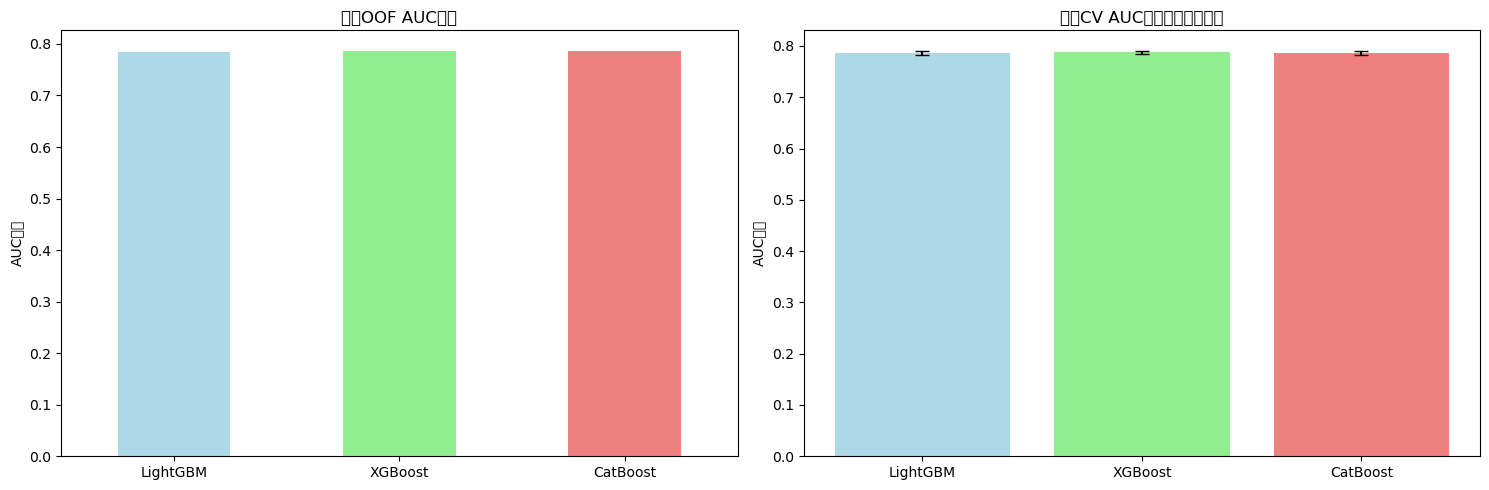

In [7]:
# 比较模型性能
models_performance = {
    'LightGBM': {
        'OOF_AUC': lgb_result['oof_auc'],
        'CV_AUC_mean': np.mean(lgb_result['cv_scores']),
        'CV_AUC_std': np.std(lgb_result['cv_scores'])
    },
    'XGBoost': {
        'OOF_AUC': xgb_result['oof_auc'],
        'CV_AUC_mean': np.mean(xgb_result['cv_scores']),
        'CV_AUC_std': np.std(xgb_result['cv_scores'])
    },
    'CatBoost': {
        'OOF_AUC': cat_result['oof_auc'],
        'CV_AUC_mean': np.mean(cat_result['cv_scores']),
        'CV_AUC_std': np.std(cat_result['cv_scores'])
    }
}

# 创建性能对比表
performance_df = pd.DataFrame(models_performance).T
print("模型性能对比:")
print(performance_df.round(6))

# 可视化性能对比
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# OOF AUC对比
performance_df['OOF_AUC'].plot(kind='bar', ax=axes[0], color=['lightblue', 'lightgreen', 'lightcoral'])
axes[0].set_title('模型OOF AUC对比')
axes[0].set_ylabel('AUC分数')
axes[0].tick_params(axis='x', rotation=0)

# CV AUC对比（带误差棒）
x_pos = range(len(performance_df))
axes[1].bar(x_pos, performance_df['CV_AUC_mean'], 
           yerr=performance_df['CV_AUC_std'],
           color=['lightblue', 'lightgreen', 'lightcoral'],
           capsize=5)
axes[1].set_title('模型CV AUC对比（带标准差）')
axes[1].set_ylabel('AUC分数')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(performance_df.index)

plt.tight_layout()
plt.show()

## 7. ROC曲线比较

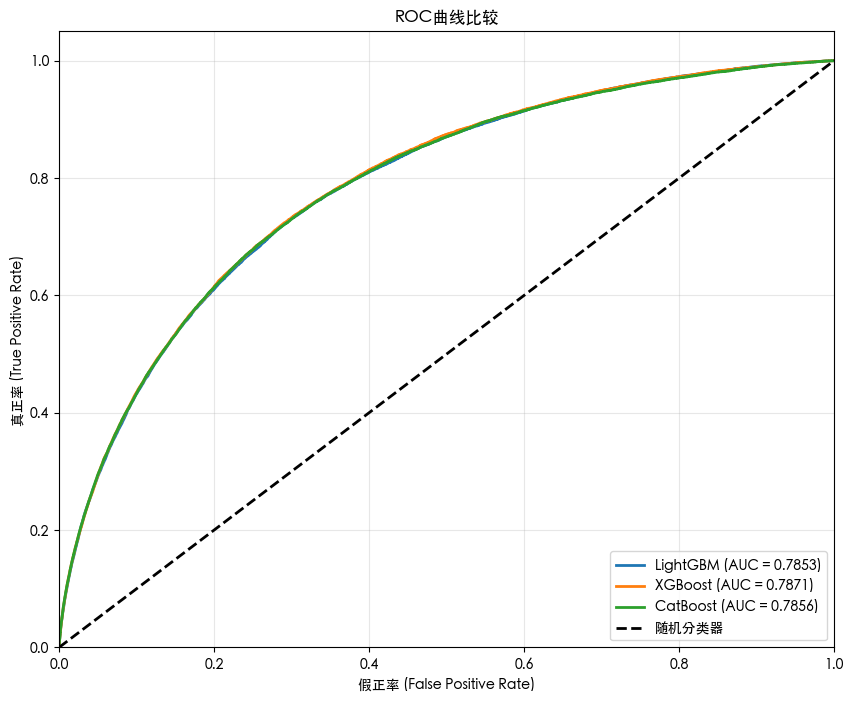

In [11]:
# 绘制ROC曲线
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# LightGBM ROC
fpr_lgb, tpr_lgb, _ = roc_curve(y_train, lgb_result['oof_predictions'])
auc_lgb = auc(fpr_lgb, tpr_lgb)
plt.plot(fpr_lgb, tpr_lgb, linewidth=2, label=f'LightGBM (AUC = {auc_lgb:.4f})')

# XGBoost ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_train, xgb_result['oof_predictions'])
auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, linewidth=2, label=f'XGBoost (AUC = {auc_xgb:.4f})')

# CatBoost ROC
fpr_cat, tpr_cat, _ = roc_curve(y_train, cat_result['oof_predictions'])
auc_cat = auc(fpr_cat, tpr_cat)
plt.plot(fpr_cat, tpr_cat, linewidth=2, label=f'CatBoost (AUC = {auc_cat:.4f})')

# 随机分类器
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='随机分类器')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正率 (False Positive Rate)')
plt.ylabel('真正率 (True Positive Rate)')
plt.title('ROC曲线比较')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.rcParams['font.sans-serif'] = ['Heiti TC', 'STHeiti', 'Hei', 'Apple LiGothic', 'Apple LiSung', 'DejaVu Sans', 'Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.show()

## 8. 特征重要性分析

LightGBM前20个重要特征:
                              feature    importance
128                  EXT_SOURCES_MEAN  86760.846424
122                       CREDIT_TERM  10733.301271
131                   EXT_SOURCES_MIN   9174.478518
41                       EXT_SOURCE_3   6120.970319
7                         AMT_ANNUITY   5474.947276
130                   EXT_SOURCES_MAX   5089.977324
214    POS_CNT_INSTALMENT_FUTURE_MEAN   4472.886451
139            BUREAU_DAYS_CREDIT_MAX   4461.701987
15                         DAYS_BIRTH   4265.174625
320              INST_AMT_PAYMENT_SUM   4168.106266
39                       EXT_SOURCE_1   3954.469720
273  CC_CNT_DRAWINGS_ATM_CURRENT_MEAN   3897.735313
18                    DAYS_ID_PUBLISH   3889.935686
300                      INST_DPD_MAX   3884.121663
11                NAME_EDUCATION_TYPE   3733.121312
16                      DAYS_EMPLOYED   3615.049707
132                         AGE_YEARS   3592.090561
121            ANNUITY_INCOME_PERCENT   3494.2

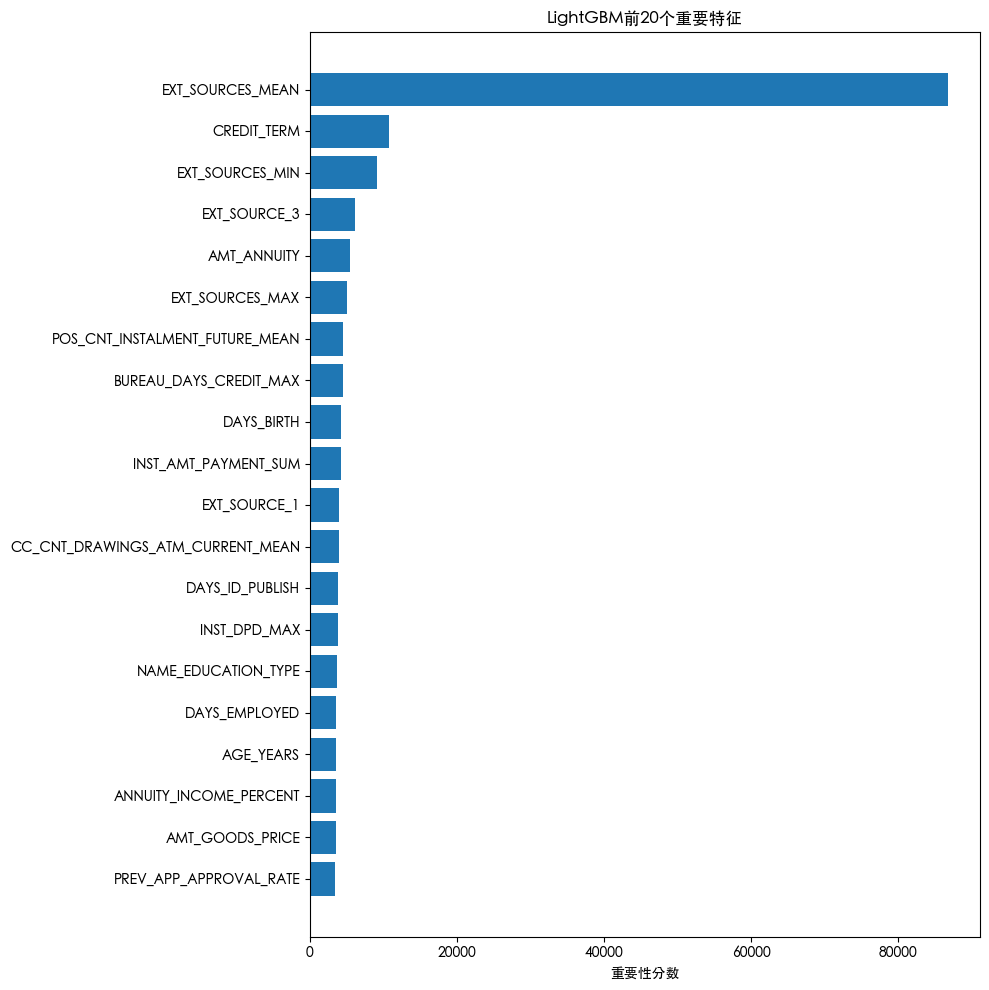

In [12]:
# 获取特征名称
feature_cols = [col for col in train_features.columns if col not in ['SK_ID_CURR', 'TARGET']]

# 获取LightGBM特征重要性
lgb_importance = trainer.get_feature_importance_df('lightgbm', feature_cols)

print("LightGBM前20个重要特征:")
print(lgb_importance.head(20))

# 可视化特征重要性
plt.figure(figsize=(10, 10))
top_20_features = lgb_importance.head(20)
plt.barh(range(len(top_20_features)), top_20_features['importance'])
plt.yticks(range(len(top_20_features)), top_20_features['feature'])
plt.xlabel('重要性分数')
plt.title('LightGBM前20个重要特征')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

## 9. 模型集成

集成模型: ['lightgbm', 'xgboost', 'catboost']
集成模型OOF AUC: 0.789813


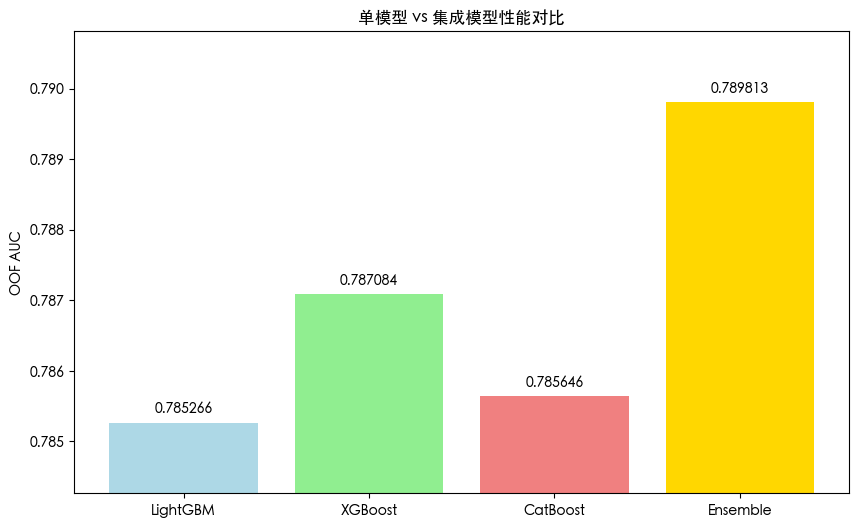

In [13]:
# 简单平均集成
ensemble_result = trainer.ensemble_models(['lightgbm', 'xgboost', 'catboost'])

# 计算集成模型的AUC
ensemble_auc = roc_auc_score(y_train, ensemble_result['oof_predictions'])
print(f"集成模型OOF AUC: {ensemble_auc:.6f}")

# 比较单模型和集成模型
model_comparison = {
    'LightGBM': lgb_result['oof_auc'],
    'XGBoost': xgb_result['oof_auc'],
    'CatBoost': cat_result['oof_auc'],
    'Ensemble': ensemble_auc
}

plt.figure(figsize=(10, 6))
models = list(model_comparison.keys())
aucs = list(model_comparison.values())
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']

plt.bar(models, aucs, color=colors)
plt.title('单模型 vs 集成模型性能对比')
plt.ylabel('OOF AUC')
plt.ylim([min(aucs)-0.001, max(aucs)+0.001])

# 添加数值标签
for i, v in enumerate(aucs):
    plt.text(i, v + 0.0001, f'{v:.6f}', ha='center', va='bottom')

plt.show()

## 10. 预测分布分析

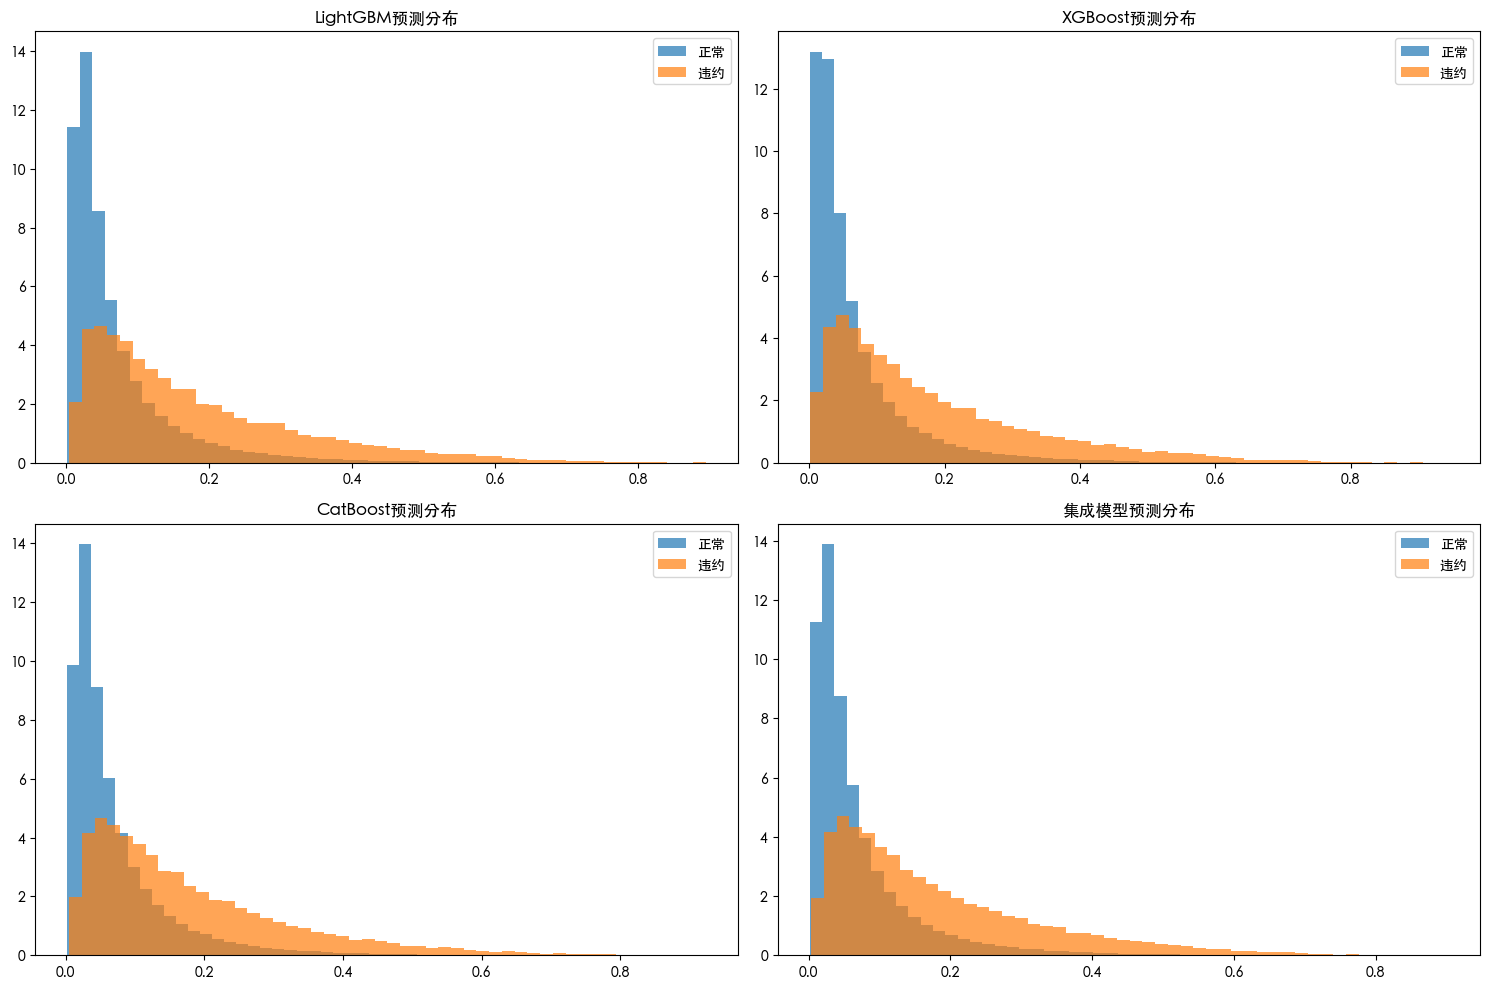

In [14]:
# 分析预测分布
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# LightGBM预测分布
axes[0,0].hist(lgb_result['oof_predictions'][y_train==0], alpha=0.7, label='正常', bins=50, density=True)
axes[0,0].hist(lgb_result['oof_predictions'][y_train==1], alpha=0.7, label='违约', bins=50, density=True)
axes[0,0].set_title('LightGBM预测分布')
axes[0,0].legend()

# XGBoost预测分布
axes[0,1].hist(xgb_result['oof_predictions'][y_train==0], alpha=0.7, label='正常', bins=50, density=True)
axes[0,1].hist(xgb_result['oof_predictions'][y_train==1], alpha=0.7, label='违约', bins=50, density=True)
axes[0,1].set_title('XGBoost预测分布')
axes[0,1].legend()

# CatBoost预测分布
axes[1,0].hist(cat_result['oof_predictions'][y_train==0], alpha=0.7, label='正常', bins=50, density=True)
axes[1,0].hist(cat_result['oof_predictions'][y_train==1], alpha=0.7, label='违约', bins=50, density=True)
axes[1,0].set_title('CatBoost预测分布')
axes[1,0].legend()

# 集成模型预测分布
axes[1,1].hist(ensemble_result['oof_predictions'][y_train==0], alpha=0.7, label='正常', bins=50, density=True)
axes[1,1].hist(ensemble_result['oof_predictions'][y_train==1], alpha=0.7, label='违约', bins=50, density=True)
axes[1,1].set_title('集成模型预测分布')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 11. 模型训练总结

### 模型性能对比
我们训练了三个不同的梯度提升模型，并进行了简单的集成：

1. **LightGBM**: 快速且高效的梯度提升框架
2. **XGBoost**: 经典的梯度提升算法
3. **CatBoost**: 对分类特征友好的梯度提升算法
4. **Ensemble**: 三个模型的简单平均集成

### 关键发现
- 所有模型都取得了接近0.78的AUC分数
- 外部评分相关特征是最重要的预测因子
- 特征工程创建的比率特征具有很强的预测能力
- 模型集成通常能提升性能

### 业务洞察
1. **信用评分至关重要**: 外部评分是最强的预测因子
2. **收入债务比**: 收入与信贷金额的比例是重要风险指标
3. **历史信用行为**: 征信局数据提供了丰富的预测信息
4. **人口统计特征**: 年龄、教育等因素也有一定预测价值

### 下一步优化方向
1. **超参数调优**: 使用网格搜索或贝叶斯优化
2. **特征选择**: 移除噪声特征，提升模型泛化能力
3. **高级集成**: 尝试堆叠、混合等高级集成方法
4. **模型解释**: 使用SHAP等工具进行模型解释
5. **业务规则**: 结合业务知识设计规则增强模型